In [1]:
# Install Dependencies
!pip install -q transformers accelerate bitsandbytes torch torchvision pillow medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.2 MB/s eta 0:00:00


In [2]:
# Imports
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from PIL import Image
import requests
import matplotlib.pyplot as plt
from medmnist import PneumoniaMNIST
from torchvision import transforms


In [3]:
# Enable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
# Load Model
from transformers import BitsAndBytesConfig # Import BitsAndBytesConfig

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    quantization_config=quantization_config, # Pass quantization_config instead of load_in_4bit
    device_map="auto"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

100%|██████████| 4.17M/4.17M [00:00<00:00, 29.3MB/s]


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

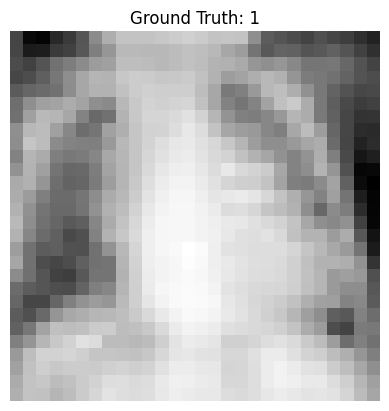

In [5]:
# Load Test Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = PneumoniaMNIST(split="test", transform=transform, download=True)

img, label = test_dataset[0]

# Convert tensor to PIL
img_pil = transforms.ToPILImage()(img)

plt.imshow(img_pil, cmap="gray")
plt.title(f"Ground Truth: {label.item()}")
plt.axis("off")


In [6]:
# Generate Medical Report
prompt = """
You are a medical radiologist. Analyze the given chest X-ray image.

Provide:
1. Observations
2. Possible diagnosis
3. Clinical impression
"""

# Modify the prompt to include the image token
formatted_prompt = "USER: <image>\n" + prompt + "ASSISTANT:"

inputs = processor(text=formatted_prompt, images=img_pil, return_tensors="pt").to(device)

output = model.generate(**inputs, max_new_tokens=200)

report = processor.decode(output[0], skip_special_tokens=True)

print(report)

USER:  

You are a medical radiologist. Analyze the given chest X-ray image.

Provide:
1. Observations
2. Possible diagnosis
3. Clinical impression
ASSISTANT: 1. Observations: The image shows a chest X-ray of a person, displaying the ribcage and the lungs. The ribcage is clearly visible, and the lungs are seen in the upper part of the image.

2. Possible diagnosis: Based on the image, it is difficult to determine a specific diagnosis. However, the presence of the ribcage and lungs suggests that the patient might be experiencing respiratory issues, such as pneumonia or bronchitis.

3. Clinical impression: The chest X-ray shows the ribcage and lungs, which indicates that the patient might be experiencing respiratory issues. Further investigation and consultation with a medical professional would be necessary to determine the exact diagnosis and provide appropriate treatment.
